In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
train_users = pd.read_csv("train_users_2.csv") #https://github.com/FraPochetti/Airbnb/blob/master/data/train_users_2.csv
test_users = pd.read_csv("test_users.csv")
df = pd.concat((train_users, test_users), axis = 0, ignore_index = True, sort = True)
del(train_users)
del(test_users)
df.gender.replace("-unknown-", np.nan, inplace=True)
df.first_browser.replace("-unknown-", np.nan, inplace=True)
df.drop("date_first_booking", axis = 1, inplace=True)
#df.age.describe()
#df.loc[df['age']>1000]['age'].describe()
#df.loc[df['age']<18]['age'].describe()
df_with_year = df['age'] > 1000
df.loc[df_with_year, 'age'] = 2015 - df.loc[df_with_year, 'age']
#df.loc[df_with_year, 'age'].describe()
df.loc[df.age > 95, 'age'] = np.nan
df.loc[df.age < 18, 'age'] = np.nan
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['timestamp_first_active'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')
df['weekday_account_created'] = df.date_account_created.dt.weekday_name
df['day_account_created'] = df.date_account_created.dt.day
df['month_account_created'] = df.date_account_created.dt.month
df['year_account_created'] = df.date_account_created.dt.year
df['weekday_first_active'] = df.timestamp_first_active.dt.weekday_name
df['day_first_active'] = df.timestamp_first_active.dt.day
df['month_first_active'] = df.timestamp_first_active.dt.month
df['year_first_active'] = df.timestamp_first_active.dt.year
df['time_lag'] = (df['date_account_created'] - df['timestamp_first_active'])
df['time_lag'] = df['time_lag'].astype(pd.Timedelta).apply(lambda l: l.days)
df.drop( ['date_account_created', 'timestamp_first_active'], axis=1, inplace=True)
df['age'].fillna(-1, inplace=True)
sessions = pd.read_csv("sessions.csv")
sessions.rename(columns = {'user_id': 'id'}, inplace=True)
action_count = sessions.groupby(['id', 'action'])['secs_elapsed'].agg(len).unstack()
action_type_count = sessions.groupby(['id', 'action_type'])['secs_elapsed'].agg(len).unstack()
action_detail_count = sessions.groupby(['id', 'action_detail'])['secs_elapsed'].agg(len).unstack()
device_type_sum = sessions.groupby(['id', 'device_type'])['secs_elapsed'].agg(sum).unstack()
sessions_data = pd.concat([action_count, action_type_count, action_detail_count, device_type_sum],axis=1)
sessions_data.columns = sessions_data.columns.map(lambda x: str(x) + '_count')

sessions_data['most_used_device'] = sessions.groupby('id')['device_type'].max()
secs_elapsed = sessions.groupby('id')['secs_elapsed']
secs_elapsed = secs_elapsed.agg(
    {
        'secs_elapsed_sum': np.sum,
        'secs_elapsed_mean': np.mean,
        'secs_elapsed_min': np.min,
        'secs_elapsed_max': np.max,
        'secs_elapsed_median': np.median,
        'secs_elapsed_std': np.std,
        'secs_elapsed_var': np.var,
        'day_pauses': lambda x: (x > 86400).sum(),
        'long_pauses': lambda x: (x > 300000).sum(),
        'short_pauses': lambda x: (x < 3600).sum(),
        'session_length' : np.count_nonzero#    
    }
)
secs_elapsed.reset_index(inplace=True)
sessions_data.index.name = 'id'
sessions_secs_elapsed = pd.merge(sessions_data, secs_elapsed, on='id', how='left')
df = pd.merge(df, sessions_secs_elapsed, on='id', how = 'left')

FileNotFoundError: [Errno 2] File b'train_users_2.csv' does not exist: b'train_users_2.csv'

In [4]:
#Encoding the categorical features
categorical_features = ['gender', 'signup_method', 'signup_flow', 'language','affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'most_used_device', 'weekday_account_created', 'weekday_first_active']
df = pd.get_dummies(df, columns=categorical_features)
df.set_index('id', inplace=True)

In [3]:
train_users = pd.read_csv("train_users_2.csv")
test_users = pd.read_csv("test_users.csv")
#Creating train dataset
train_df = df.loc[train_users['id']]
train_df.reset_index(inplace=True)
train_df.fillna(-1, inplace=True)
#Creating target variable for the train dataset
y_train = train_df['country_destination']
train_df.drop(['country_destination', 'id'], axis=1, inplace=True)

In [4]:
test_df = df.loc[test_users['id']].drop('country_destination', axis=1)
test_df.reset_index(inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [5]:
train_df = train_df.loc[:,~train_df.columns.duplicated()]
#test_df.columns[test_df.columns.duplicated()]
test_df = test_df.loc[:,~test_df.columns.duplicated()]

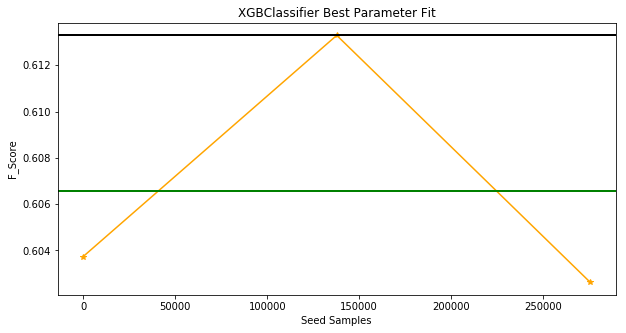

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
import sklearn.metrics as metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import tree
#***************************************************INPUTS***********************************************************************

#Below are Naive Bayes model types
#These are the three models we'll be testing. To best attempt F_score maxima, models will have no prior fit from previous attempts.
#GaussianNB is false in this way by default.
#model_type = [BernoulliNB(fit_prior=False),GaussianNB(),MultinomialNB(fit_prior=False),XGBClassifier(),tree.DecisionTreeClassifier()]

#Neural nets can also be used but will take longer to converge
#model_type = [MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2)),MLPClassifier(solver='adam', alpha=1e-5,max_iter=10000,hidden_layer_sizes=(5, 2)),MLPClassifier(solver='sgd', alpha=1e-5,max_iter=10000,hidden_layer_sizes=(5, 2))]

#Naive Bayes has obtained ~ 0.43 F fit, Neural Nets ~ 0.56 though unreliably. Going to lastly test xgb and decision tree F test.
model_type = [XGBClassifier()] #max_depth=10,num_class=12

#Each model/train size/seeds converges on a different solution. How many subdivisions of starting points would you like to try?
seeds = 3
#The model(s) perform differently with different amounts of training. How many equally spaced percentages would you like to send?
train_steps = 3
target = 'country_destination'
value = 'NDF'

#*******************************************************************************************************************************

#Makes ndarray of equally spaced train fractions to send to the model.
train_frac = np.linspace(0.1,0.9,train_steps)
#Makes ndarray of equally spaced starting points for the model to find convergence over the sample space.
states = np.linspace(0,df.shape[0],seeds, dtype=int)

#Creating test set
#test_df = df.loc[test_users['id']].drop('country_destination', axis=1)
#test_df.reset_index(inplace=True)
#id_test = test_df['id']
#test_df.drop('id', axis=1, inplace=True)

Y = y_train
#Xt = pd.get_dummies(test_df)
#X = pd.get_dummies(train_df)
X = train_df

#This class assesses the fitness metrics of the trained model
def fit_model(X,Y,states,model,train_size):
    #Iterate over each starting point seed, a different starting state
    for state in states:
        #Take the model type passed in
        clf = model
        #train_test_split randomly splits the data into a train_size fraction of how much data the model is trained with
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=train_size, random_state=state)
        #the model is fitted based on the training data
        clf = clf.fit(X_train, Y_train)
        #Ignoring warnings from model because it may not be able to have sufficient data to predict every target
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            #Precision & Recall are each different statistical measures of fitness
            #Precision is true positives/(true positives + false positives)
            precision = metrics.precision_score(Y_test, clf.predict(X_test), average='weighted')
            #Recall is true positives/(true positives + false negatives)
            recall = metrics.recall_score(Y_test, clf.predict(X_test), average='weighted')
            #F score is the weighted mean of precision and recall
            f_score = 2/(1/precision+1/recall)
        F = f_score
        #y_pred = clf.predict(X_test)
        results_params[state] = F
    return results_params

#Set parameter names to be part of dictionary
params = ['F','state','train_size']
#Create empty dictionary of these parameter names
param_dict = {param: None for param in params}
#Create empty dictionary to be filled with each model to each parameter dictionary
model_dict = {model_name: param_dict for model_name in model_type}
#Iterate over input model types
for model in model_type:
    #Make empty dictionaries for interim use
    df3_params, results_params = {},{}
    #Iterate over what fraction of data is fed to model
    for train_size in train_frac:
        #Obtain results as dictionaries of seed sample states to each resultant F_score/ill_defined_sites from the model
        results_params = fit_model(X,Y,states,model,train_size)
        #Put each result in a dictionary for the train size used
        df3_params.update({train_size:pd.Series(results_params)})
        
    #Make empty dictionary to be filled with the best parameters for each model
    best = {}
    #Iterate over the train sizes to store the best F_score and its best parameters
    for key in df3_params.keys():
        #If this F_score is the first one or the maximum so far, store the settings
        if not best or best['F'] < df3_params[key].max():
            #Store this in the best dictionary
            best = {'train_size':key,'state':df3_params[key].idxmax(),'F':df3_params[key].max()}
    #If the highest F_score for that model was not 0
    if best['F']:
        #Store the best settings and F_score for each model
        model_dict.update({model:best})
    else:
        #Drop that model from the dictionary if it has no F_score
        model_dict.pop(model)
        
#Make empty dictionary to store the best model and its settings in
results_params, best_model = {}, {}

#Build a dictionary of the best model's settings based on F score
for model in model_dict.keys():
    #If dictionary empty or current iterated F score is better than stored value
    if not best_model or best_model['F'] < model_dict[model]['F']:
        #Store the train size
        model_train_size = model_dict[model]['train_size']
        #Store the random seed state
        model_state = model_dict[model]['state']
        #Store the best F score
        model_F = model_dict[model]['F']
        #Create the best model dictionary
        best_model = {'model': model,'state':model_state,'train_size':model_train_size,'F':model_F}

#Fit the model with these best settings
results_params = fit_model(X,Y,states,best_model['model'],best_model['train_size'])

#Find out how much the avg_F of a model run with optimal parameters differs from the best F obtained from all models/train sizes/seeds
total = 0
for key in results_params.keys():
    total += results_params[key]
avg_F = total/len(results_params.keys())

#The rest is building the graph
#Import regular expressions
import re
#This pulls out the model name from the full name including all its settings
title = re.search('[^(]*',str(best_model['model']))
solver = re.search("solver='.*'",str(best_model['model']))
#Size of the figure in x and y
plt.figure(figsize=(10,5))
#Plot the F score against the random starting seed
plt.plot(results_params.keys(), results_params.values(), color='orange',marker='*')
#Horizontal green line as the average of this best model run across starting seeds
plt.axhline(y=avg_F,linewidth=2, color='g')
#Horizontal black line as the best value
plt.axhline(y=best_model['F'],linewidth=2, color='black')
#Display the regular expression of the model plus more about the graph
#If MLPClassifier Neural Nets were used, want to include the solver type in the title
if (title.group(0) == "MLPClassifier"):
    plt.title(title.group(0) + " " + solver.group(0) +' Best Parameter Fit')
#Otherwise, just show the type of Naive Bayes model that was best which is just in title alone
else:
    plt.title(title.group(0) + ' Best Parameter Fit')
#Label x
plt.xlabel('Seed Samples')
#Label y
plt.ylabel('F_Score');

In [7]:
best_model

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=100, n_jobs=1, nthread=None,
        objective='multi:softprob', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
        subsample=1, verbosity=1),
 'state': 137773,
 'train_size': 0.9,
 'F': 0.6132920181623189}

In [ ]:
clf = XGBClassifier(max_depth=10,
    learning_rate=1,
    n_estimators=100,
    objective='count:poisson',
    num_class=12,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    missing=None,
    nthread=4,
    seed=42)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=best_model['train_size'], random_state=best_model['state'])
clf = clf.fit(X_train, Y_train)
y_pred_train = clf.predict(X)
sum(y_train == y_pred_train)/y_train.size*100

In [18]:
unique, counts = np.unique(y_pred_train, return_counts=True)
dict(zip(unique, counts))

{'AU': 99,
 'CA': 340,
 'DE': 236,
 'ES': 550,
 'FR': 1567,
 'GB': 592,
 'IT': 703,
 'NDF': 140914,
 'NL': 158,
 'PT': 25,
 'US': 64177,
 'other': 4090}

In [19]:
Xt = pd.get_dummies(test_df)
y_pred = clf.predict(Xt)

C:\Users\mmcgown\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
predict = pd.DataFrame(np.column_stack((test_users['id'],y_pred)), columns=['id', 'country'])

In [21]:
predict.head()
predict.to_csv('prediction.csv',index=False)